# Classify stimulus movie clips using python convnets

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
from time import time
import re
from os import listdir
from os.path import isfile, join
from scipy import misc
from scipy.stats import pearsonr
import scipy.io
from lnl_model_functions import *

from matplotlib.pyplot import *
import mpld3

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scikits/__init__.py:1: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


# Load labels

In [9]:
labels_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/labels'
filename   = 'all.txt'

text_file = open(labels_dir + '/' + filename, "r")
spikes = text_file.read().split('\t')
#cells.append([float(spike) for spike in spikes if not ((not spike) or (spike.startswith("c")))])

text_file.close()

In [10]:
# labels are numCell tuples
s_prev = 0.0
eachCell = []
cells = []
for ids,s in enumerate(spikes):
    if '\r' in s:
        newSpikes = re.split('\r', s)
        if 'NAN' in newSpikes[0]:
            cells.append(eachCell)
            eachCell = []
            if newSpikes[1] == '':
                continue
            else:
                eachCell.append(float(newSpikes[1]))
        else:
            eachCell.append(float(newSpikes[0]))
            cells.append(eachCell)
            eachCell = []
            eachCell.append(float(newSpikes[1]))
    elif 'NAN' in s:
        continue
    else:
        eachCell.append(float(s))        

In [11]:
print 'There are %d cells.' %(shape(cells)[0])

There are 22 cells.


In [12]:
longest_duration = max([max(c) for c in cells])

In [13]:
precision = 0.02 #0.010 # 10 ms
numBins   = int(ceil(longest_duration/precision))+1

In [14]:
numCells = shape(cells)[0]
labels = np.zeros((numCells, numBins))

for idc,c in enumerate(cells):
    for s in c:
        myBin = int(ceil(s/precision))
        # even if more than one spike in this bin, threshold at 1
        labels[idc, myBin] = 1

# Load stimulus

In [15]:
stimulus_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/generate_frames/spatial_white'
filename_prefix = 'frame'
filename_suffix = '.png'

In [16]:
allfiles = [f for f in listdir(stimulus_dir) if isfile(join(stimulus_dir,f)) and '.png' in f]
print 'There are %d files.' %(len(allfiles))

There are 4000 files.


In [17]:
test = misc.imread(stimulus_dir + '/' + filename_prefix + str(1) + filename_suffix, flatten=True)

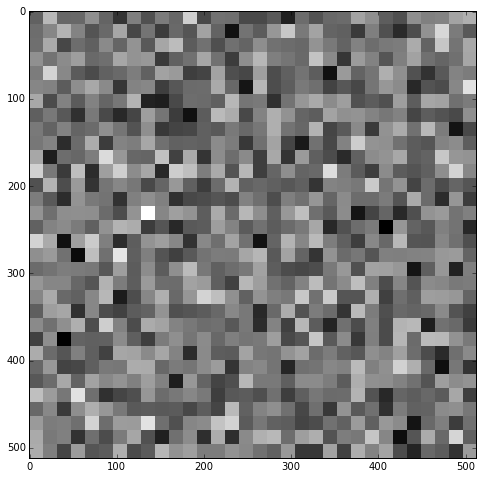

In [18]:
imshow(test)

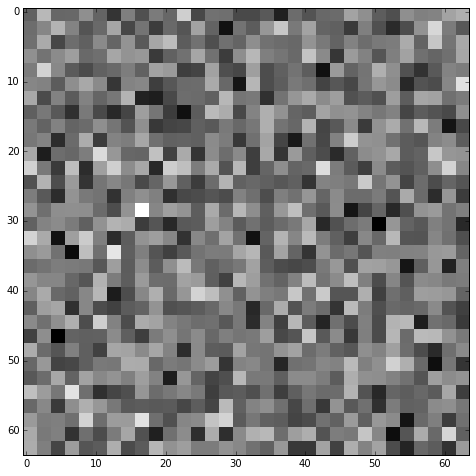

In [19]:
imshow(test[::8,::8])

In [20]:
test[::8,::8].shape

(64, 64)

In [21]:
maxNumExamples = 4500
subsampleFactor = 8

framesPerExample = 20
numExamples = min(len(allfiles) - framesPerExample + 3, maxNumExamples)
test = misc.imread(stimulus_dir + '/' + filename_prefix + str(1) + filename_suffix, flatten=True)
test = test[::subsampleFactor,::subsampleFactor]
examples = np.zeros((numExamples, framesPerExample, test.shape[0], test.shape[1]), dtype=uint8)
for i in xrange(min(len(allfiles), maxNumExamples + framesPerExample + 1)):
    if i % 1000 == 0:
        print 'Done with %d out of %d examples.' %(i, numExamples)
    im = misc.imread(stimulus_dir + '/' + filename_prefix + str(i+1) + filename_suffix, flatten=True)
    examplesWithFrame = min(framesPerExample,i+1)
    pairs = [(ex+max(0,i-framesPerExample+1),examplesWithFrame-1-ex) for ex in xrange(examplesWithFrame) if ex+max(0,i-framesPerExample+1) < numExamples]
    for p in pairs:
        examples[p[0],p[1],:,:] = im[::8,::8]
    

Done with 0 out of 3983 examples.
Done with 1000 out of 3983 examples.
Done with 2000 out of 3983 examples.
Done with 3000 out of 3983 examples.


In [22]:
examples.shape

(3983, 20, 64, 64)

# Get timing information

In [23]:
timing_dir = '/Users/lmcintosh/Git/deepRGC/datasets/experiment_2013_02_27/labels'
stim = scipy.io.loadmat(timing_dir + '/' + '20130227T112709.mat')
stim_vars = stim['ex']
stim_vals = stim_vars[0,0]

In [24]:
numFrames = stim_vals['ds']['vbl'][0][0].shape[0]
startStim = stim_vals['ds']['vbl'][0][0][0,0];
startData = 0;
normalizedTime = stim_vals['ds']['vbl'][0][0] - startStim;     # frames x conditions
exptLength = max(normalizedTime.flat)/60;   # in minutes
trialLength = size(normalizedTime,0);       # in frames
frameLength = (stim_vals['ds']['vbl'][0][0][trialLength-1,0] - stim_vals['ds']['vbl'][0][0][0,0])/(trialLength-1)
#stim_vals['ds']['vbl'][0][0][1,0] - stim_vals['ds']['vbl'][0][0][0,0];  # in seconds
trialDur = trialLength*frameLength;         # in seconds
numTrials = int(round(exptLength*60/trialDur))
numTrialsPerCondition = 10

stimType = [stim_vals['pa']['stimType'][0][0][i][0][0] for i in xrange(numTrials)]

In [25]:
normalizedTime.shape

(4000, 40)

In [26]:
def raster(event_times_list, color='k'):
    """
    Creates a raster plot
 
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
 
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = gca()
    for ith, trial in enumerate(event_times_list):
        vlines(trial, ith + .5, ith + 1.5, color=color,linewidth=1.3)
    ylim(.5, len(event_times_list) + .5)
    
    return ax

In [27]:
n = 0
allTrials = []
for trial in xrange(normalizedTime.shape[1]):
    start = normalizedTime[0,trial]
    end   = normalizedTime[-1,trial]
    allTrials.append([s-start for s in cells[n] if end >= s and start <= s])
    


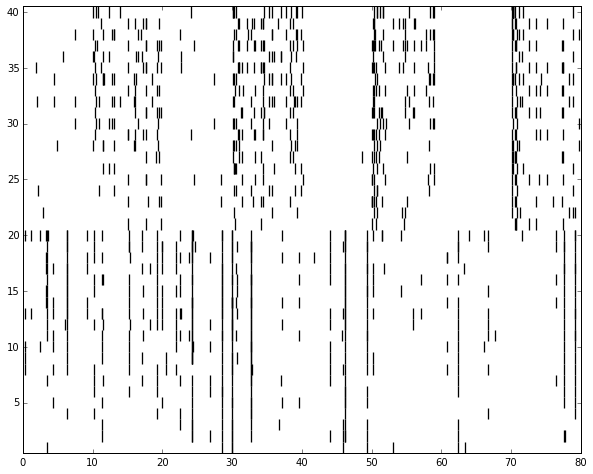

In [28]:
raster(allTrials)

In [29]:
binsPerTrial = int(ceil(trialDur*50))

# Smooth raw spike trains with 10ms std Gaussian to get PSTHs

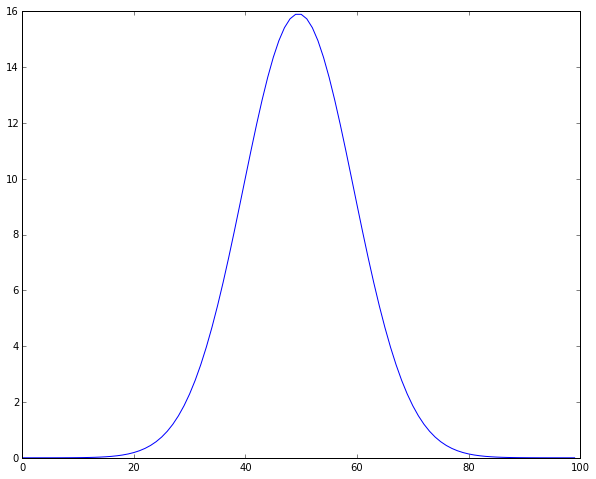

In [30]:
filt = gaussian(x=np.linspace(-.50,.50,100), sigma=.1, mu=0)
plot(filt)

In [31]:
labels_aligned = np.zeros((numCells, binsPerTrial, normalizedTime.shape[1]))
for n in xrange(numCells):
    for trial in xrange(normalizedTime.shape[1]):
        labels_aligned[n,:,trial] = labels[n, trial*binsPerTrial:(trial+1)*binsPerTrial]

numSpatialWhiteTrials = 20
spatialWhitePSTH = {}
for n in xrange(numCells):
    spatialWhitePSTH[n] = np.sum(labels_aligned[n,:,:numSpatialWhiteTrials], axis=1)/numSpatialWhiteTrials
    trueMean = np.mean(spatialWhitePSTH[n])
    spatialWhitePSTH[n] = np.convolve(filt, spatialWhitePSTH[n],'same')
    spatialWhitePSTH[n] *= trueMean / np.mean(spatialWhitePSTH[n])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


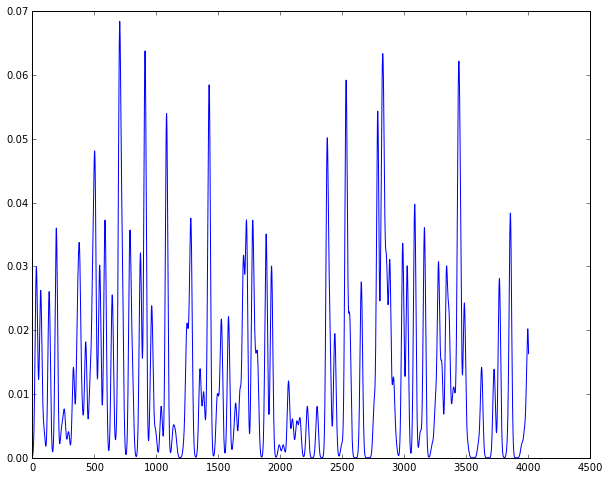

In [32]:
plot(spatialWhitePSTH[3])

In [33]:
correlations = {}
for n in xrange(numCells):
    correlations[n] = np.nanmean([pearsonr(spatialWhitePSTH[n], np.convolve(filt,labels_aligned[n,:,t],mode='same'))[0] for t in xrange(numSpatialWhiteTrials)])

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scipy/stats/stats.py:2436: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:607: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [34]:
allCorrs = array(correlations.values())

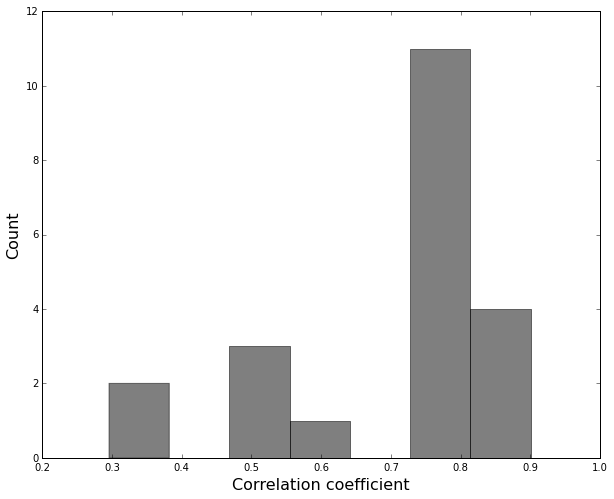

In [35]:
hist(allCorrs[~isnan(allCorrs)], 7, facecolor='k', alpha=0.5)
xlabel('Correlation coefficient', fontsize=16)
ylabel('Count', fontsize=16)

## Which neuron is the most precise?

In [36]:
best_neuron = np.nanargmax(allCorrs)

In [37]:
correlations[best_neuron]

0.90036172279360316

In [38]:
spatialWhitePSTH[best_neuron].shape

(4003,)

# Troubleshoot stimulus  
Why is the network just learning the average firing rate?

### STA

In [39]:
# for now choose a neuron
n = best_neuron

In [40]:
# Since I'm now using PSTHs, we have to restrict the number of examples to a single trial
X = examples[:spatialWhitePSTH[best_neuron].shape[0]-framesPerExample]
numExamples = X.shape[0]

# Zero-mean the data
mean_img = np.mean(X, axis=0)
X -= mean_img

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:7: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


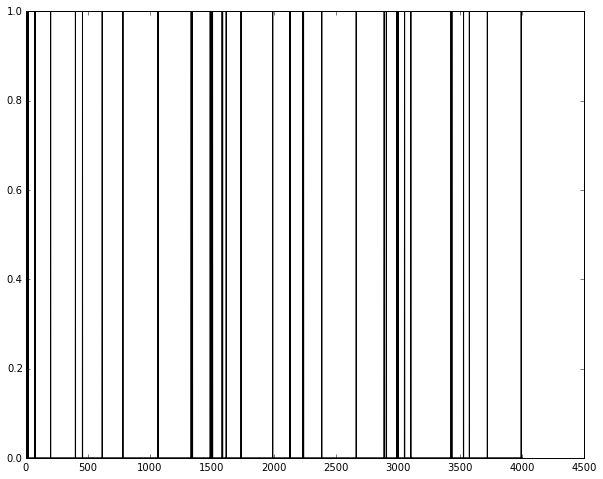

In [41]:
plot(labels_aligned[n, :, 0], 'k')

In [42]:
X.shape

(3983, 20, 64, 64)

In [43]:
labels_aligned[n, framesPerExample: , 0].shape

(3983,)

In [44]:
def sta(stimulus, spiketrain, numFrames=20):
    numSpikes = np.sum(spiketrain)
    sta = np.dot(stimulus.T, spiketrain)
    sta /= numSpikes
    return sta.T    

In [45]:
mySTA = sta(X, labels_aligned[n, framesPerExample:, 0])

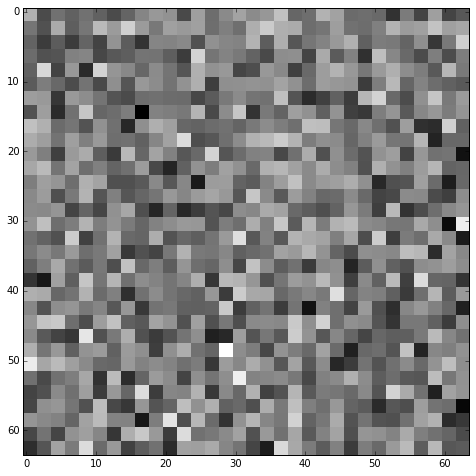

In [46]:
imshow(mySTA[10])

# Nothing really there. Let's simulate data using an LN model

In [6]:
from lnl_model_functions import *

In [7]:
fake_data_shape = (16,16)
framesPerExample = 20

<matplotlib.colorbar.Colorbar instance at 0x110826518>

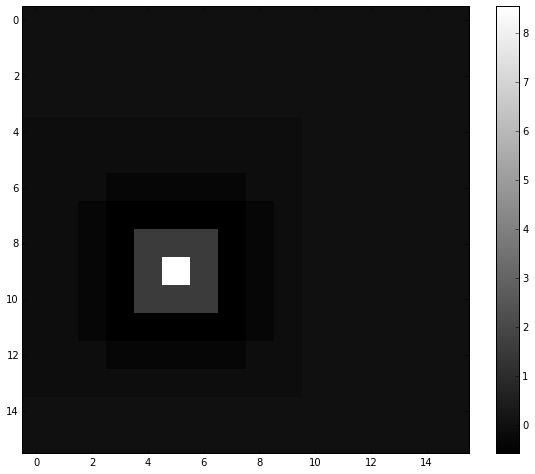

In [8]:
filterSize = 10
sfilter    = np.zeros(fake_data_shape) # 64 x 64
positions  = np.random.choice(len(sfilter)-filterSize, 2)
sfilter[positions[0]:positions[0]+filterSize, positions[1]:positions[1]+filterSize] = spatial_filter_2d(xs_num=filterSize)
imshow(sfilter)
colorbar()

### Make spatiotemporal receptive field

In [9]:
stfilter = np.ones((framesPerExample, sfilter.shape[0], sfilter.shape[1]))
stfilter *= sfilter

In [10]:
tfilter = cos(np.linspace(0,10,20))- 2*sin(.51*np.linspace(0,10,20)) - 1

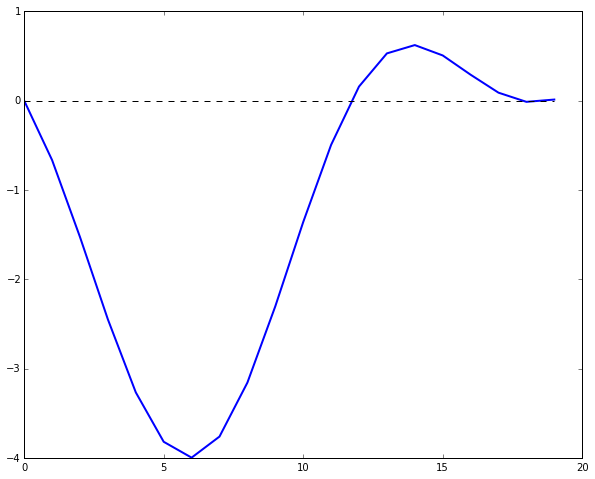

In [11]:
plot(tfilter, linewidth=2)
plot(np.zeros(len(tfilter)), 'k--')

In [12]:
stfilter = stfilter.T * tfilter
stfilter = stfilter.T

### Generate stimuli

In [13]:
stfilter.shape

(20, 16, 16)

In [14]:
numExamples = 10000
X = np.random.randn(numExamples, stfilter.shape[0], stfilter.shape[1], stfilter.shape[2])

In [25]:
y = X * stfilter

In [26]:
y = np.sum(y, axis=(1,2,3))

In [27]:
y.shape

(10000,)

### whiten $y$

In [28]:
y /= np.std(y)
y -= np.mean(y)

In [29]:
np.var(y)

1.0000000000000056

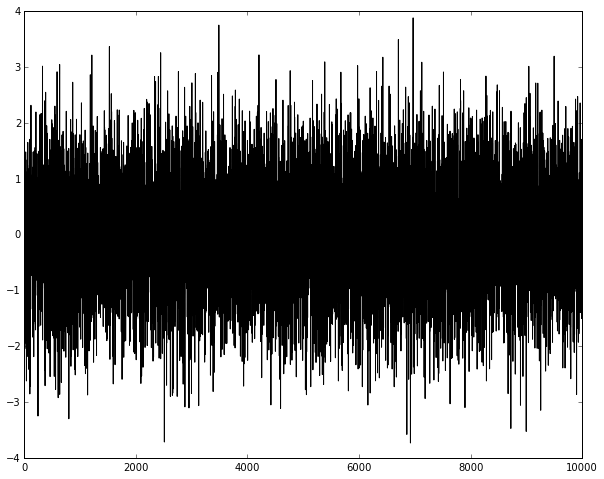

In [30]:
plot(y, 'k')

In [33]:
#nonlinear = 'logistic'
nonlinear = 'ReLU'

if nonlinear == 'ReLU':
    y = np.maximum(y, 0)
    y /= np.max(y)
elif nonlinear == 'logistic':
    y *= 10.
    y = 1. / (1 + np.exp(-y))
elif nonlinear == 'sigmoid':
    y = nonlinearity(y, theta=2.5*np.std(y), g=3.)

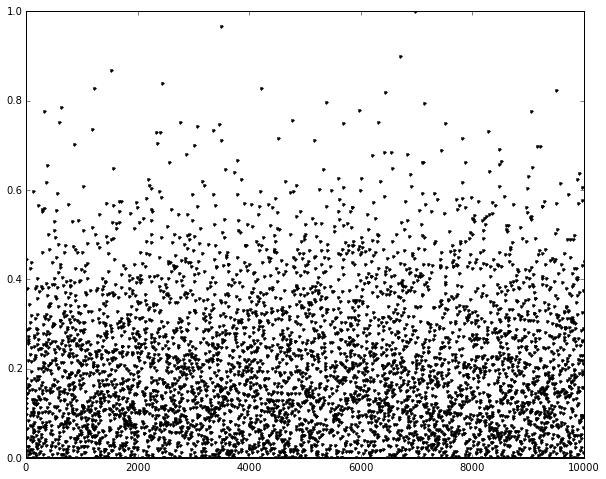

In [34]:
plot(y, 'k.')

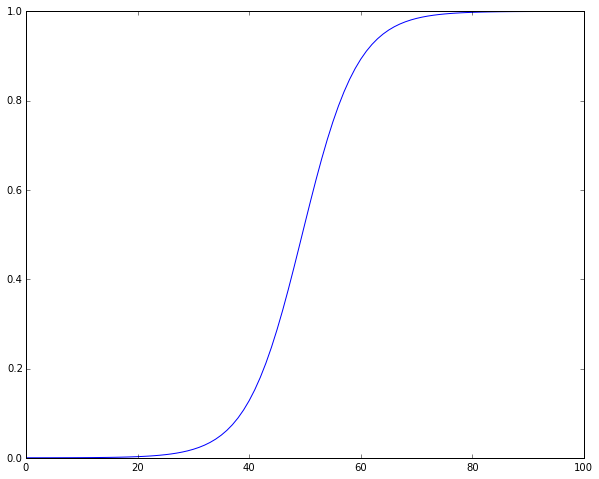

In [35]:
plot(1. / (1 + np.exp(-np.linspace(-10,10,100))))

# Train a 3 layer network

In [37]:
from utils.classifiers.convnet import init_three_layer_convnet
from utils.classifiers.convnet import three_layer_convnet

In [38]:
model = init_three_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=9, 
                               num_filters=(16, 32), weight_scale=1e-3) 
# weight_scale=0.015, 0.07 , weight_obs=X_sta.flat

In [43]:
# Divide examples into training, validation, and test sets
numTrain = 5000
numVal   = 250
numTest  = 250

drawIndices = np.random.choice(X.shape[0], size=(numTrain+numVal+numTest), replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[-numTest:]

# don't need to zero mean data since we loaded stim_norm

In [57]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 7e-5
reg = 0.0 #0.001
dropout = 1.0
num_epochs = 4

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


#best_model = None
#best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(X, y, trainMask, 
                                                                                  valMask, model, three_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=250, verbose=True,
                                                                                 acc_frequency=50, save_plots=False)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history

starting iteration  0
Finished epoch 0 / 4: cost 0.235095, train: 0.925075, val 0.710699, lr 7.000000e-05
starting iteration  10
Train preds in (0.000065, 0.293154), val preds in (0.000370, 0.292131), truth in (0.000000, 0.867692).
Finished epoch 1 / 4: cost 0.227662, train: 0.934641, val 0.720185, lr 6.650000e-05
starting iteration  20
starting iteration  30
Train preds in (0.000191, 0.293807), val preds in (0.000222, 0.293154), truth in (0.000000, 0.899989).
Finished epoch 2 / 4: cost 0.273827, train: 0.928810, val 0.718434, lr 6.317500e-05
starting iteration  40
starting iteration  50
Train preds in (0.000081, 0.294092), val preds in (0.000206, 0.293807), truth in (0.000000, 0.899989).
Finished epoch 2 / 4: cost 0.263186, train: 0.927035, val 0.719526, lr 6.317500e-05
Train preds in (0.000033, 0.294296), val preds in (0.000179, 0.294092), truth in (0.000000, 0.777180).
Finished epoch 3 / 4: cost 0.242736, train: 0.941730, val 0.721038, lr 6.001625e-05
starting iteration  60
starting

In [58]:
tmp = model.copy()

# Train a network!

In [75]:
from utils.classifiers.convnet import init_five_layer_convnet
from utils.classifiers.convnet import five_layer_convnet

In [76]:
X[0,:,:,:].shape

(20, 16, 16)

In [77]:
model = init_five_layer_convnet(input_shape=X[0,:,:,:].shape, num_classes=1, filter_sizes=(11,5,5), 
                                  num_filters=(2,2,4,8))

#### For fake data

In [78]:
# Divide examples into training, validation, and test sets
drawIndices = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
trainMask = drawIndices[:len(drawIndices)/2]
valMask   = drawIndices[len(drawIndices)/2:len(drawIndices)/2+len(drawIndices)/4]
testMask  = drawIndices[len(drawIndices)/2+len(drawIndices)/4:]

X_train = X[trainMask]
X_val   = X[valMask]
X_test  = X[testMask]

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

In [79]:
# move labels into same space as X
y_train = y[trainMask]
y_val   = y[valMask]
y_test  = y[testMask]

#### For real data

In [80]:
# # Since I'm now using PSTHs, we have to restrict the number of examples to a single trial
# X = examples[:spatialWhitePSTH[best_neuron].shape[0]-framesPerExample]
# numExamples = X.shape[0]

# # Divide examples into training, validation, and test sets
# trainMask = np.random.choice(X.shape[0], size=X.shape[0]/2, replace=False)
# valMask   = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)
# testMask  = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)

# X_train = X[trainMask]
# X_val   = X[valMask]
# X_test  = X[testMask]

# # Zero-mean the data
# mean_img = np.mean(X_train, axis=0)
# X_train -= mean_img
# X_val -= mean_img
# X_test -= mean_img

In [81]:
# # for now choose a neuron
# n = best_neuron

# # move labels into same space as X
# # the following works only when label precision is same as X
# #y = labels[n, framesPerExample:(numExamples+framesPerExample)].astype(int)
# y = spatialWhitePSTH[best_neuron] / np.max(spatialWhitePSTH[best_neuron])
# y = y[framesPerExample:(numExamples+framesPerExample)]

# y_train = y[trainMask]
# y_val   = y[valMask]
# y_test  = y[testMask]

In [82]:
y_train.shape

(5000,)

In [83]:
y_val.shape

(2500,)

In [84]:
X_val.shape

(2500, 20, 16, 16)

## Overtrain a subset

In [90]:
X_train_subset = X_train[:3000]
y_train_subset = y_train[:3000]
X_val_subset   = X_val[:2000]
y_val_subset   = y_val[:2000]

In [91]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-3
reg = 0.000
dropout = 1.0
num_epochs = 3

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_err = np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_err_history, val_err_history = trainer.train(X_train_subset, y_train_subset, X_val_subset, y_val_subset,
                                model, five_layer_convnet,
                                learning_rate=learning_rate, reg=reg, update='rmsprop',
                                dropout=dropout, num_epochs=num_epochs, batch_size=50,
                                verbose=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.min(val_err_history) < best_val_err:
    best_model = finetuned_model
    best_val_err = np.min(val_err_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

starting iteration  0
Finished epoch 0 / 3: cost 3.541255, train: 0.319540, val 0.321909, lr 5.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 1 / 3: cost 3.564821, train: 0.315539, val 0.320503, lr 4.750000e-03
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
Finished epoch 2 / 3: cost 3.602398, train: 0.327897, val 0.320506, lr 4.512500e-03
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
Finished epoch 3 / 3: cost 3.658302, train: 0.331712, val 0.320524, lr 4.286875e-03
finished optimization. best validation error: 0.320503


In [118]:
print 'Best reg %f, best lr %f.' %(reg_hist.keys()[np.argmin(reg_hist.values())], lr_hist.keys()[np.argmin(lr_hist.values())])

Best reg 0.035938, best lr 0.046416.


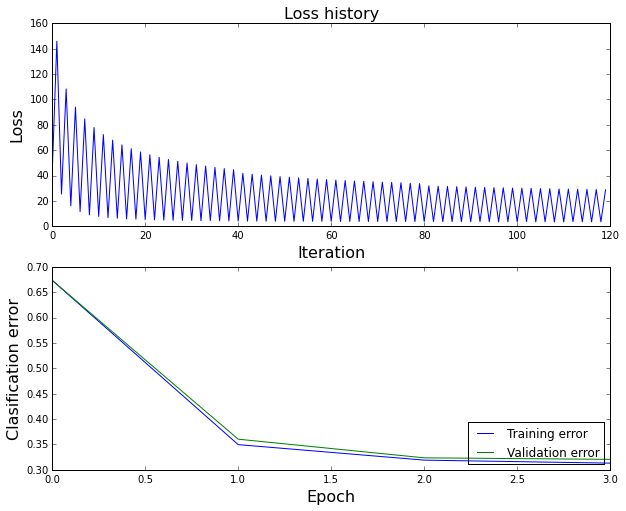

In [87]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_err_history)
plt.plot(val_err_history)
plt.legend(['Training error', 'Validation error'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Clasification error', fontsize=16)

# Grad check logistic_backward

In [24]:
from utils.layers import logistic_forward
from utils.layers import logistic_backward

In [34]:
example_x = randn(1)
example_y = randn(1)

In [35]:
out, cache = logistic_forward(example_x, np.array([1.,1.,0.1]))
dx, dparams = logistic_backward(1., cache)
#print 'Loss is %f, and grad has length %d.' %(loss, grad.shape[0])

In [36]:
# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: logistic_forward(w, np.array([1.,1.,0.1]))[0]
grad_numerical = grad_check_sparse(f, example_x, dx, 10)

numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12
numerical: 0.243253 analytic: 0.243253, relative error: 1.090811e-12


# Grad check new mse_loss function

In [20]:
from utils.layers import mse_loss

In [21]:
example_x = randn(750)
example_y = randn(750)

In [22]:
loss, grad = mse_loss(example_x, example_y)
print 'Loss is %f, and grad has length %d.' %(loss, grad.shape[0])

Loss is 2.055975, and grad has length 750.


In [23]:
# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: mse_loss(w, example_y)[0]
grad_numerical = grad_check_sparse(f, example_x, grad, 10)

numerical: -0.000542 analytic: -0.000542, relative error: 7.068531e-09
numerical: 0.003518 analytic: 0.003518, relative error: 1.693270e-09
numerical: 0.003240 analytic: 0.003240, relative error: 1.465284e-09
numerical: -0.001655 analytic: -0.001655, relative error: 1.388646e-09
numerical: 0.002140 analytic: 0.002140, relative error: 1.777664e-09
numerical: 0.000922 analytic: 0.000922, relative error: 1.829488e-09
numerical: 0.000425 analytic: 0.000425, relative error: 5.584782e-10
numerical: 0.005947 analytic: 0.005947, relative error: 1.403405e-09
numerical: -0.001094 analytic: -0.001094, relative error: 8.204113e-09
numerical: -0.001262 analytic: -0.001262, relative error: 1.164950e-10


#### Checks out!

# Grad check new cross_entropy_loss function

In [368]:
from utils.layers import cross_entropy_loss

In [369]:
example_x = randn(150)
example_y = 1./(1+np.exp(-randn(150)))

In [370]:
loss, grad = cross_entropy_loss(example_x, example_y)
print 'Loss is %f, and grad has length %d.' %(loss, grad.shape[0])

Loss is 0.841205, and grad has length 150.


In [371]:
# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: cross_entropy_loss(w, example_y)[0]
grad_numerical = grad_check_sparse(f, example_x, grad, 10)

numerical: 0.001624 analytic: 0.001624, relative error: 4.605407e-10
numerical: -0.000172 analytic: -0.000172, relative error: 1.993378e-08
numerical: 0.002277 analytic: 0.002277, relative error: 2.174394e-10
numerical: -0.004936 analytic: -0.004936, relative error: 3.821473e-10
numerical: 0.003164 analytic: 0.003164, relative error: 1.141294e-10
numerical: 0.002425 analytic: 0.002425, relative error: 1.497274e-09
numerical: -0.000807 analytic: -0.000807, relative error: 1.702051e-09
numerical: -0.005392 analytic: -0.005392, relative error: 6.247348e-10
numerical: -0.000964 analytic: -0.000964, relative error: 1.868306e-09
numerical: 0.002727 analytic: 0.002727, relative error: 6.670759e-10


#### Checks out!

# What does the prediction look like?

In [88]:
probs = five_layer_convnet(X_val_subset, finetuned_model, return_probs=True)

In [89]:
plot(np.linspace(0,len(y_val_subset)*precision,len(y_val_subset)), y_val_subset, 'k', linewidth=1)
plot(np.linspace(0,len(y_val_subset)*precision,len(y_val_subset)), probs, 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [183]:
np.mean(probs)

0.13187999805235004

In [184]:
np.mean(y_train_subset)

0.12382447177247746

# Try with a 3 layer network

In [269]:
from utils.classifiers.convnet import init_three_layer_convnet
from utils.classifiers.convnet import three_layer_convnet

In [270]:
model = init_three_layer_convnet(input_shape=X[0,:,:,:].shape, num_classes=1, filter_size=11,
                                 num_filters=(16,32), weight_scale=.2) # weight_scale was .75, then .1

# Overtrain a subset

In [271]:
X_train_subset = X_train[:3000]
y_train_subset = y_train[:3000]
X_val_subset   = X_val[:2000]
y_val_subset   = y_val[:2000]

In [274]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 1e-3
reg = 0.001 #0.001
dropout = None
num_epochs = 5

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train_subset, y_train_subset,
                                                                                  X_val_subset, y_val_subset,
                                                                                  model, three_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=50, verbose=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

starting iteration  0
Finished epoch 0 / 5: cost 11369.292322, train: 0.117589, val 0.035570, lr 1.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 1 / 5: cost 8063.397869, train: 0.154910, val 0.038147, lr 9.500000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
Finished epoch 2 / 5: cost 6270.394570, train: 0.276602, val 0.032032, lr 9.025000e-04
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
Finished epoch 3 / 5: cost 4944.920341, train: 0.320807, val 0.056095, lr 8.573750e-04
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
Finished epoch 4 / 5: cost 3946.310758, train: 0.376468, val 0.086438, lr 8.145062e-04

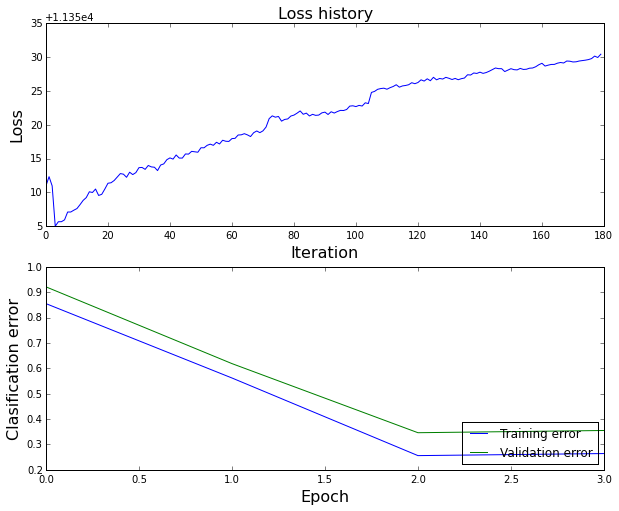

In [180]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)

In [185]:
#probs = three_layer_convnet(X_train_subset, finetuned_model, return_probs=True)
sub = 500 # len(y_train_subset)
plot(np.linspace(0,sub*precision,sub), y_train_subset[:sub], 'k', linewidth=1)
plot(np.linspace(0,sub*precision,sub), probs[:sub], 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [182]:
corrcoef(probs.squeeze(), y_train_subset)

array([[ 1.        ,  0.78943008],
       [ 0.78943008,  1.        ]])

In [183]:
pearsonr(probs.squeeze(), y_train_subset)

(0.78943008404557791, 0.0)

In [238]:
probs = three_layer_convnet(X_val_subset, finetuned_model, return_probs=True)
sub = 100 # len(y_val_subset)
plot(np.linspace(0,sub*precision,sub), y_val_subset[:sub], 'k', linewidth=1)
plot(np.linspace(0,sub*precision,sub), probs[:sub], 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [239]:
scores = three_layer_convnet(X_val_subset, finetuned_model, return_probs=False)

(array([    3.,     8.,    10.,    38.,    85.,   326.,  1326.,   679.,
           22.,     3.]),
 array([-11.86035392, -10.38140091,  -8.9024479 ,  -7.42349489,
         -5.94454187,  -4.46558886,  -2.98663585,  -1.50768283,
         -0.02872982,   1.45022319,   2.92917621]),
 <a list of 10 Patch objects>)

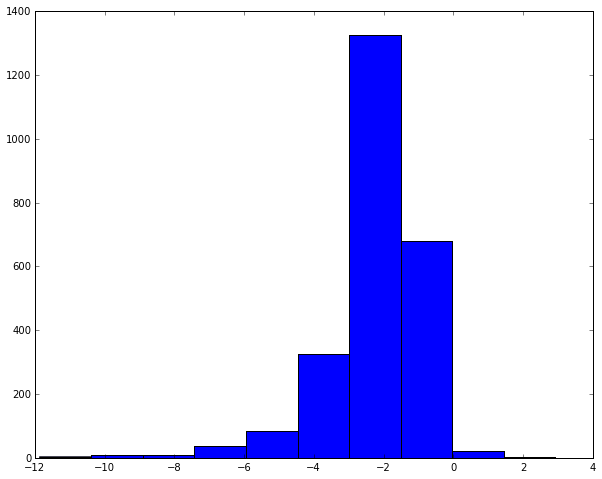

In [240]:
hist(scores)

In [121]:
np.min(scores)

-452.42671793726839

In [122]:
np.max(scores)

549.03816948697033

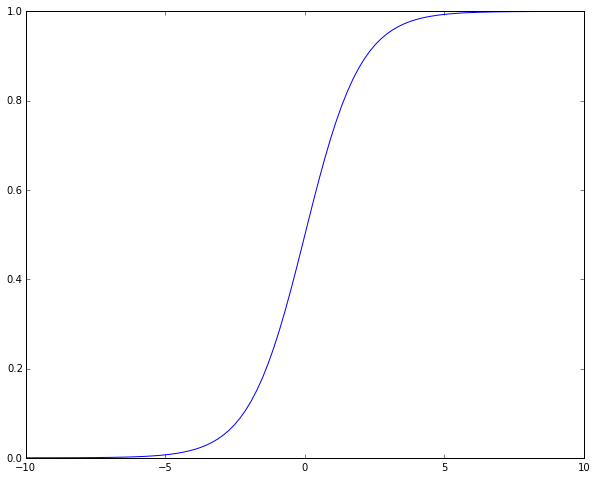

In [123]:
zed = np.linspace(-10,10,100)
plot(zed, 1. / (1. + np.exp(-zed)))

In [124]:
np.log2(5)

2.3219280948873622

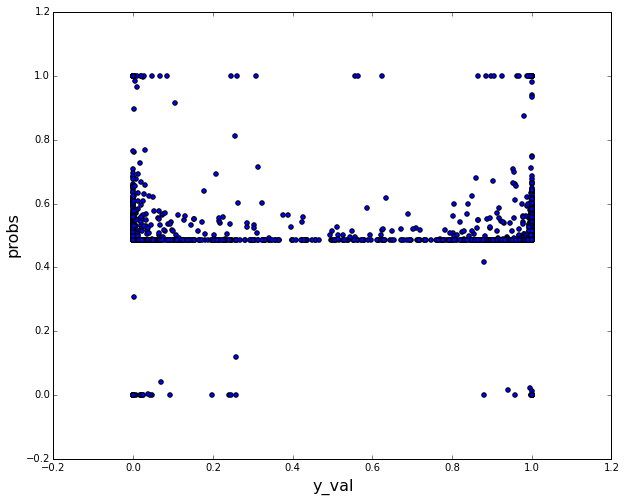

In [125]:
scatter(y_val_subset, probs)
xlabel('y_val', fontsize=16)
ylabel('probs', fontsize=16)

In [170]:
new_probs = probs.copy()
new_probs[probs==0.0] = 10e-200
new_probs[probs==1.0] = 1. - 10e-15
losses  = -y_val_subset*np.log(new_probs.squeeze()) - (1.-y_val_subset)*np.log(1.-new_probs.squeeze())

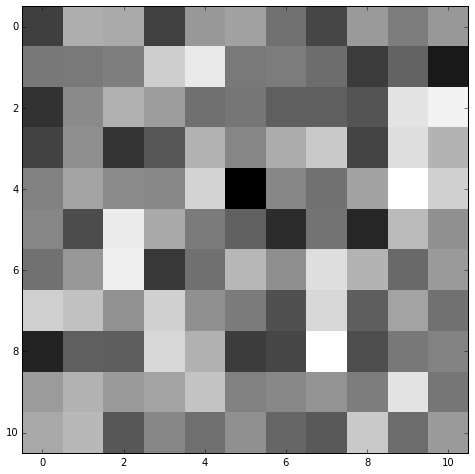

In [257]:
imshow(finetuned_model['W1'][0,5,:,:])

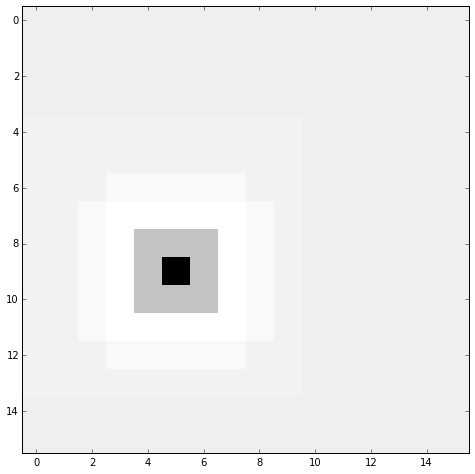

In [256]:
imshow(stfilter[5,:,:])

In [93]:
from utils.layers import cross_entropy_loss

In [141]:
iters = 10000
diffs = []
errors = []
for i in xrange(iters):
    y = rand(1)
    d = .25*randn(1)
    probs = y + d
    if abs(probs) >= 1.:
        continue
    else:
        diffs.append(d)
        errors.append(-y*np.log(probs) - (1.-y)*np.log(1.-probs))

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in log


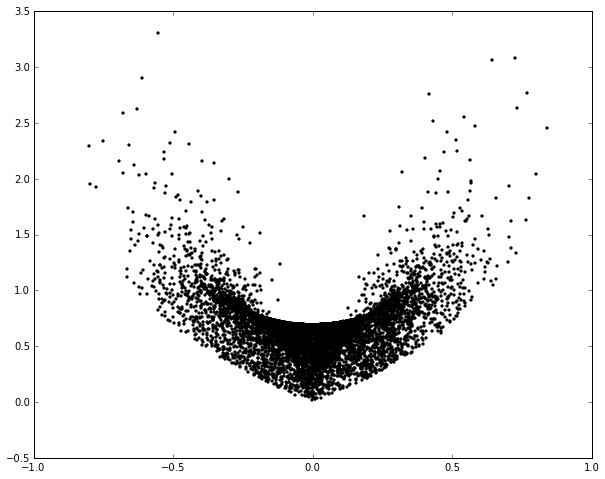

In [142]:
scatter(diffs, errors, c='k', s=5)

In [45]:
def fitTotalLNModel(inputData, modelOutput):
    modelOutput = modelOutput.reshape((len(modelOutput), 1, 1, 1))
    sta = inputData * modelOutput
    return np.sum(sta, axis=0)

In [59]:
X.shape

(10000, 20, 16, 16)

In [61]:
Z = randn(30000, 20, 16, 16)

In [62]:
batch_size = 250
probs = np.zeros((Z.shape[0],))
iterations = Z.shape[0] / batch_size
for it in xrange(iterations):
    probs[it*batch_size:(it+1)*batch_size] = three_layer_convnet(Z[it*batch_size:(it+1)*batch_size], model).squeeze()

In [63]:
modelSTA = fitTotalLNModel(Z, probs)

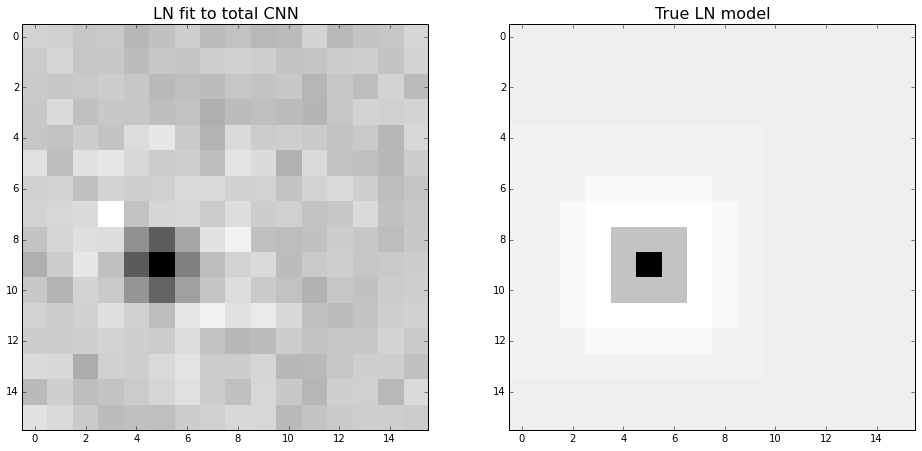

In [64]:
fig = gcf()
fig.set_size_inches((16,8))
subplot(1,2,1)
imshow(modelSTA[3,:,:])
title('LN fit to total CNN', fontsize=16)
subplot(1,2,2)
imshow(stfilter[3,:,:])
title('True LN model', fontsize=16)

In [253]:
r, alpha = pearsonr(randn(len(y_train_subset)), y_train_subset)

In [275]:
pwd

u'/Users/lmcintosh/Git/deepRGC/python'

In [276]:
cd ../datasets/white_noise

/Users/lmcintosh/Git/deepRGC/datasets/white_noise


In [277]:
ls

rates.mat*  stim0a.mat* stim0b.mat*


In [278]:
from scipy.io import loadmat

In [282]:
newRates = loadmat('rates.mat', squeeze_me=True, struct_as_record=False)

In [283]:
newRates['rates'].shape

(299890, 11)

In [284]:
newStim1 = loadmat('stim0a.mat', squeeze_me=True, struct_as_record=False) 

In [286]:
newStim1.keys()

['stimulus', '__version__', '__header__', '__globals__']

In [287]:
newStim1['stimulus'].shape

(100, 100, 149945)

In [288]:
newStim2 = loadmat('stim0b.mat', squeeze_me=True, struct_as_record=False) 

In [289]:
newStim = np.concatenate((newStim1['stimulus'], newStim2['stimulus']), axis=2)

In [290]:
newStim.shape

(100, 100, 299890)

In [291]:
from nems.utilities import rolling_window

ImportError: No module named nems.utilities

In [ ]:
rolling_window(newStim, 40)

In [3]:
10e-6

1e-05

In [111]:
def cross_entropy(x,y):
    aboveZero = (y > 0)
    belowOne  = ((1. - y) > 0)
    
    rates = x.copy()
    rates[rates<=0.0] = 10e-4
    rates[rates>=1.0] = 1. - 10e-4
    
#     x[x<=0.0] = 10e-15
#     x[x>=1.0] = 1. - 10e-15
    
    losses = np.zeros(rates.shape)
    losses[aboveZero] -= y[aboveZero] * np.log(rates[aboveZero])
    losses[belowOne]  -= (1. - y[belowOne]) * np.log(1. - rates[belowOne])
    
#     dx = -y/x + (1.-y)/(1-x)
    dx = -y/rates + (1.-y)/(1.-rates)
    dx /= rates.shape[0]
    
    
    return np.mean(losses), dx

In [115]:
y = rand(4)
x = randn(4)

print cross_entropy(x,y)[0]
# print (-y*np.log(x), -(1.-y)*np.log(1.-x))

print x - y
print cross_entropy(x,y)[1]

0.98817155996
[-1.11359179 -0.73494182 -0.91724819  0.02951561]
[ -2.23352812e+01  -1.67846369e+01  -7.84447917e+01   3.08113529e-02]


In [116]:
x

array([-1.02334   , -0.66687041, -0.6027828 ,  0.60253536])

In [117]:
y

array([ 0.09025178,  0.06807141,  0.31446539,  0.57301974])

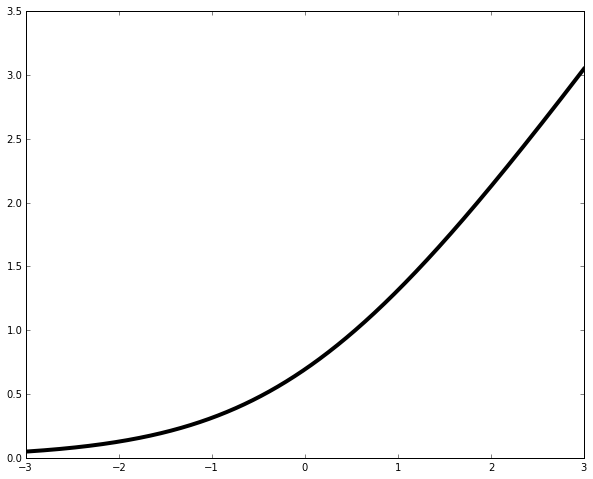

In [70]:
xs = np.linspace(-3, 3, 1000)
plot(xs, np.log(1 + np.exp(xs)), 'k', linewidth=4)
savefig('soft_rectification.png')